# Quantitative Crypto Strategies: Technical vs. Sentiment Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Introduction

Cryptocurrency markets have grown from a niche speculative asset class to a multi-trillion dollar market with institutional participation. Unlike traditional equities, crypto markets operate 24/7 with high volatility, creating unique opportunities for systematic trading strategies. This research evaluates two distinct approaches to alpha generation in crypto markets:

1. **Technical Strategy**: Channel Breakout, a momentum-based strategy exploiting price continuation patterns
2. **Sentiment Strategy**: Google trends sentiment analysis, capturing crowd psychology through social media signals

### Motivation

While Bitcoin and major altcoins have delivered extraordinary long-term returns, their volatility and frequent drawdowns make passive buy-and-hold challenging. Systematic strategies aim to outperform simple hodling by actively managing risk and capturing momentum during uptrends while reducing exposure during downturns.

### Research Questions

This project addresses three core questions:

1. **Which strategy generates superior risk-adjusted returns?** Measured by Sharpe ratio, alpha, and drawdown characteristics.

2. **Do technical and sentiment signals provide independent sources of alpha?** Assessed through correlation analysis and diversification benefits.

3. **What portfolio construction choices optimize performance?** Comparing fixed-weight vs. fully-invested allocation and universe size (top 10 vs. top 80 coins).

### Data and Methodology

We backtest both strategies on daily cryptocurrency price data from 2020-2025, covering a full market cycle including bull markets (2020-2021), bear markets (2022), and recovery (2023-2025). Google trends data is sourced directly from google with the parameters - worldwide, past 5 years, all categories, web searches for each coin by name not by ticker, aggregated weekly. All strategies are tested out-of-sample with a train-test split, and transaction costs of 20 basis points per trade are incorporated.

### Key Findings Preview

Both strategies significantly outperform Bitcoin (Sharpe ratio 2.04-2.43 vs. ~1.0 for BTC). However, they exhibit moderate correlation (0.58), limiting diversification benefits. The sentiment-based strategy delivers higher Sharpe (2.43) and return (132.9%), while the technical strategy offers lower turnover and simpler implementation.

In [2]:
prices = pd.read_csv(r'E:\crypto_prices_fixed.csv')
prices['time'] = pd.to_datetime(prices['time'])
prices.set_index('time', inplace=True)
prices

,BTC,XRP,BNB,ADA,LINK,ZEC,TRX,LTC,PAXG,AVAX,...,CTC,KSM,ARPA,NMR,WAVES,PRO,ARK,ETH,SOL,DOGE
time,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15599.92,0.2458,27.72,0.09772,11.01,56.77,0.02500,59.00,1951.55,3.351,...,0.5479,30.50,0.01461,23.47,3.4300,0.08986,0.3019,414.07,1.41,0.002617
2020-11-06,15590.62,0.2589,29.05,0.10930,12.18,61.61,0.02615,63.36,1956.62,3.596,...,0.5443,32.55,0.01676,24.16,3.5660,0.08778,0.3240,454.72,1.91,0.002760
2020-11-07,14838.16,0.2494,27.78,0.10130,11.76,57.42,0.02495,58.98,1966.06,3.411,...,0.5593,31.22,0.01656,22.89,3.4380,0.07924,0.3030,435.71,2.03,0.002671
2020-11-08,15488.25,0.2538,28.42,0.10680,12.72,60.62,0.02536,61.00,1964.57,3.466,...,0.5842,32.99,0.01821,23.30,3.5180,0.08131,0.3361,453.55,2.16,0.002711
2020-11-09,15335.03,0.2506,28.11,0.10540,12.52,58.44,0.02485,59.24,1897.32,3.410,...,0.5913,33.26,0.01765,23.73,3.7900,0.08864,0.3582,444.16,2.03,0.002670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17,106485.41,2.2940,1072.31,0.62470,16.61,217.91,0.30900,90.15,4240.57,19.960,...,0.4313,10.50,0.02031,12.94,0.8476,0.55510,0.3205,3832.56,182.03,0.184842
2025-10-18,107228.76,2.3600,1092.66,0.63450,16.82,221.61,0.31300,91.72,4244.48,20.210,...,0.4447,10.55,0.02080,13.27,0.8364,0.55680,0.3217,3890.35,187.66,0.189599
2025-10-19,108701.79,2.3910,1110.93,0.65300,17.29,236.34,0.32050,93.34,4243.58,20.590,...,0.4526,10.95,0.02061,13.38,0.8457,0.57560,0.3294,3984.65,187.80,0.195323


In [3]:
prices_top10 = prices[['BTC','ETH','BNB','XRP','ADA','SOL','TRX','XLM','LINK','BCH']]

In [4]:
returns = prices_top10.pct_change()

In [5]:
end_of_insample = pd.Timestamp('2024-08-31')
in_sample_prices = prices_top10.loc[:end_of_insample]
out_of_sample_prices = prices_top10.loc[end_of_insample:]
in_sample_returns = returns.loc[:end_of_insample]
out_of_sample_returns = returns.loc[end_of_insample:]

## Part 1: Channel Breakout Strategy

### Strategy Logic

The Channel Breakout strategy is a momentum-based technical approach that identifies trending markets by detecting when price breaks out of its recent trading range. The intuition is simple: when an asset breaks above its recent highs or below its recent lows, it signals the start of a new directional move.

#### Signal Generation

For each cryptocurrency, we calculate:

1. **Upper Channel**: The maximum price over the past `N` days (lookback period)
2. **Lower Channel**: The minimum price over the past `N` days

**Long Signal**: Price closes above the upper channel → Enter long position  
**Short Signal**: Price closes below the lower channel → Enter short position  
**Exit**: When the opposite signal triggers or position is no longer in the top N coins

This is a classical Donchian Channel breakout, popularized by the Turtle Traders in the 1980s and adapted here for crypto markets.

#### Portfolio Construction

We test two allocation approaches:

- **Fixed-Weight**: Allocate 1/N of capital to each active signal (e.g., 10% per coin for top 10). Remaining capital stays in cash.
- **Fully-Invested**: Normalize weights across active signals to ensure 100% capital deployment at all times.

Fixed-weight limits exposure during weak signal periods, while fully-invested maximizes capital efficiency but concentrates risk.

In [ ]:
def backtest_channel_breakout_with_mode(prices_df, Y=None, X=None, N=None, M=None, mode='fixed'):
    
    prices_df = prices_df.copy()
    returns = prices_df.pct_change()
    
    num_coins = len(prices_df.columns)
    fixed_weight = 1.0 / num_coins
    
    long_positions = pd.DataFrame(0, index=prices_df.index, columns=prices_df.columns)
    short_positions = pd.DataFrame(0, index=prices_df.index, columns=prices_df.columns)
    
    # LONG STRATEGY
    if Y is not None and X is not None:
        rolling_high_long = prices_df.rolling(window=Y, min_periods=Y).max()
        rolling_low_long = prices_df.rolling(window=X, min_periods=X).min()
        
        entry_signal_long = (prices_df > rolling_high_long.shift(1))
        exit_signal_long = (prices_df < rolling_low_long.shift(1))
        
        for col in prices_df.columns:
            in_long = False
            for i in range(len(prices_df)):
                if not in_long and entry_signal_long.iloc[i][col]:
                    in_long = True
                    long_positions.iloc[i][col] = 1
                elif in_long and exit_signal_long.iloc[i][col]:
                    in_long = False
                    long_positions.iloc[i][col] = 0
                elif in_long:
                    long_positions.iloc[i][col] = 1
    
    # SHORT STRATEGY
    if N is not None and M is not None:
        rolling_low_short = prices_df.rolling(window=N, min_periods=N).min()
        rolling_high_short = prices_df.rolling(window=M, min_periods=M).max()
        
        entry_signal_short = (prices_df < rolling_low_short.shift(1))
        exit_signal_short = (prices_df > rolling_high_short.shift(1))
        
        for col in prices_df.columns:
            in_short = False
            for i in range(len(prices_df)):
                if not in_short and entry_signal_short.iloc[i][col]:
                    in_short = True
                    short_positions.iloc[i][col] = 1
                elif in_short and exit_signal_short.iloc[i][col]:
                    in_short = False
                    short_positions.iloc[i][col] = 0
                elif in_short:
                    short_positions.iloc[i][col] = 1
    
    combined_positions = long_positions - short_positions
    weights = pd.DataFrame(0.0, index=prices_df.index, columns=prices_df.columns)
    
    if mode == 'fixed':
        weights = combined_positions * fixed_weight
    elif mode == 'fully_invested':
        for period in combined_positions.index:
            total_positions = combined_positions.loc[period].abs().sum()
            if total_positions > 0:
                weights.loc[period] = combined_positions.loc[period] / total_positions
            else:
                weights.loc[period] = 0
    
    portfolio_returns = (weights.shift(1) * returns).sum(axis=1)
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    daily_sharpe = mean_return / std_return if std_return != 0 else 0
    
    return daily_sharpe, portfolio_returns, weights


### Parameter Optimization

We optimize three parameters using a fixed train-test split:

- **Entry Lookback (Y)**: [10, 15, 20, ..., 95, 100] days (increments of 5)
- **Exit Lookback (X)**: [5, 10, 15, ..., 55, 60] days (increments of 5)
- **Allocation Method**: [Fixed-Weight, Fully-Invested]

**Training Period**: 2020-2024 (used to select optimal parameters based on Sharpe ratio)  
**Test Period**: 2024-2025 (held out for validation to assess out-of-sample performance)

The **entry lookback** determines the channel width for generating buy/sell signals (e.g., Y=20 means a 20-day high/low channel). The **exit lookback** controls when to close positions (e.g., X=10 means exit when price crosses the 10-day channel in the opposite direction). Using separate entry and exit periods allows the strategy to capture longer trends while exiting quickly when momentum reverses.



In [7]:
Y_values = range(10, 101, 5)
X_values = range(5, 61, 5)

long_sharpe_matrix_fixed = np.zeros((len(X_values), len(Y_values)))
long_sharpe_matrix_invested = np.zeros((len(X_values), len(Y_values)))

for i, Y in enumerate(Y_values):
    for j, X in enumerate(X_values):
        if X < Y:
            # Fixed-weight mode
            daily_sharpe_fixed, _, _ = backtest_channel_breakout_with_mode(
                in_sample_prices,
                Y=Y,
                X=X,
                mode='fixed'
            )
            long_sharpe_matrix_fixed[j, i] = daily_sharpe_fixed
            
            # Fully-invested mode
            daily_sharpe_invested, _, _ = backtest_channel_breakout_with_mode(
                in_sample_prices,
                Y=Y,
                X=X,
                mode='fully_invested'
            )
            long_sharpe_matrix_invested[j, i] = daily_sharpe_invested
        else:
            long_sharpe_matrix_fixed[j, i] = np.nan
            long_sharpe_matrix_invested[j, i] = np.nan

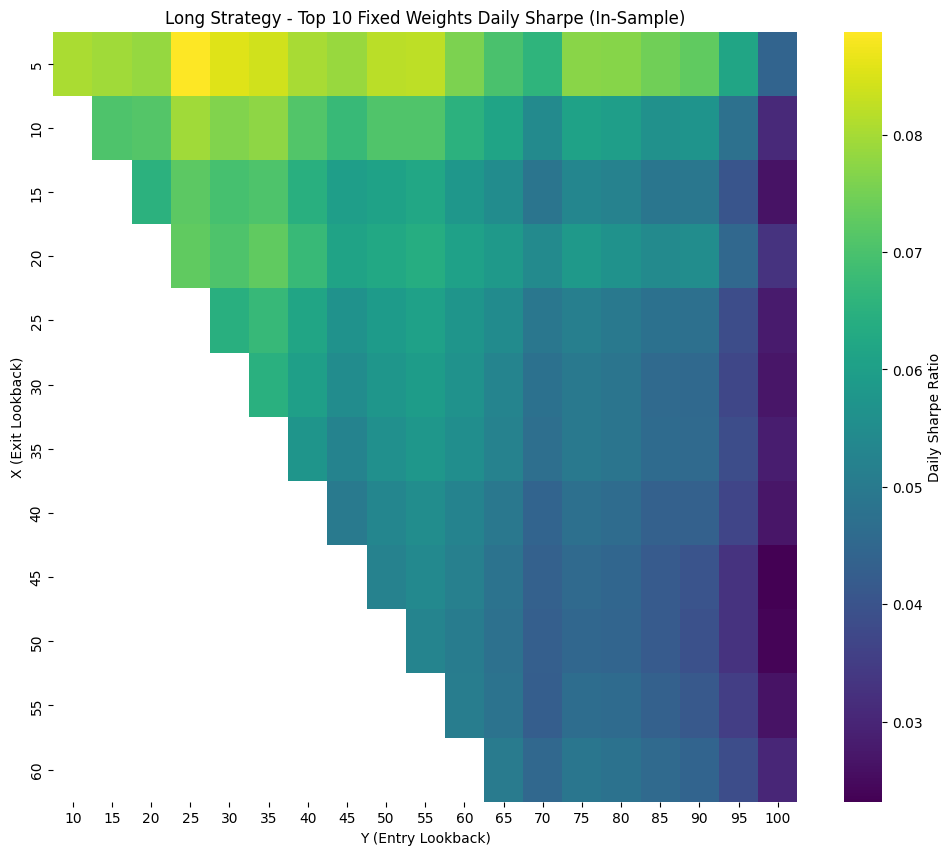

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(long_sharpe_matrix_fixed, xticklabels=Y_values, yticklabels=X_values, 
            cmap='viridis', annot=False, cbar_kws={'label': 'Daily Sharpe Ratio'})
plt.xlabel('Y (Entry Lookback)')
plt.ylabel('X (Exit Lookback)')
plt.title('Long Strategy - Top 10 Fixed Weights Daily Sharpe (In-Sample)')
plt.show()


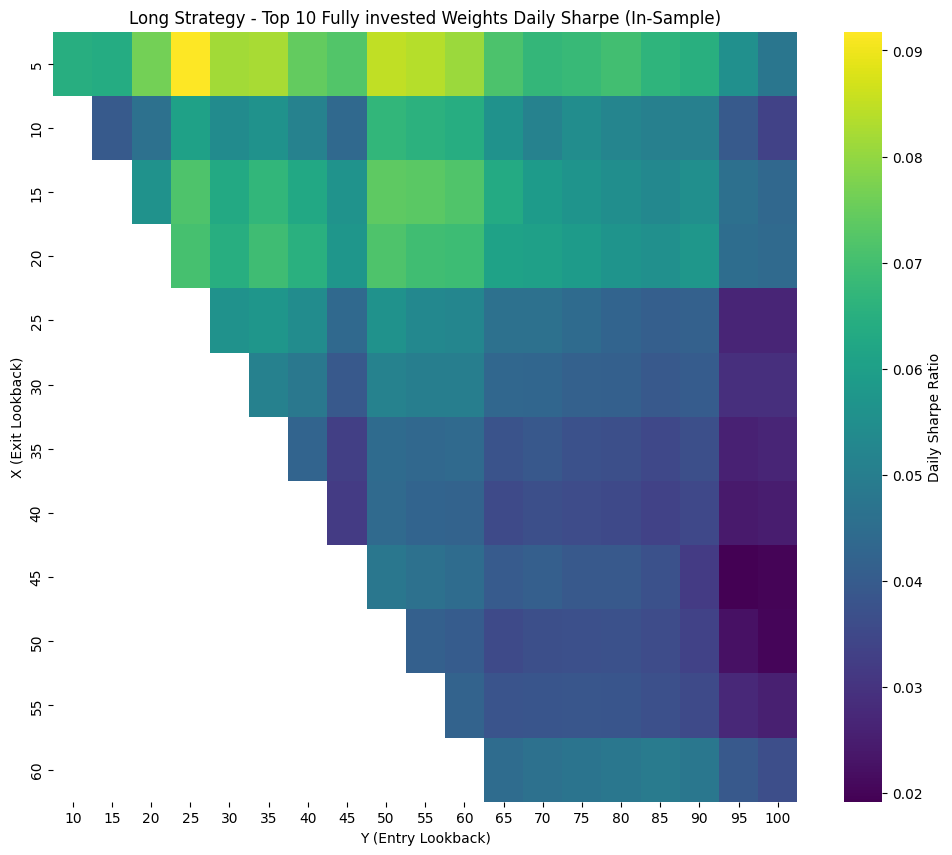

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(long_sharpe_matrix_invested, xticklabels=Y_values, yticklabels=X_values, 
            cmap='viridis', annot=False, cbar_kws={'label': 'Daily Sharpe Ratio'})
plt.xlabel('Y (Entry Lookback)')
plt.ylabel('X (Exit Lookback)')
plt.title('Long Strategy - Top 10 Fully invested Weights Daily Sharpe (In-Sample)')
plt.show()

In [10]:
N_values = range(10, 101, 5)
M_values = range(5, 61, 5)

short_sharpe_matrix_fixed = np.zeros((len(M_values), len(N_values)))
short_sharpe_matrix_invested = np.zeros((len(M_values), len(N_values)))

for i, N in enumerate(N_values):
    for j, M in enumerate(M_values):
        if M < N:
            # Fixed-weight mode
            daily_sharpe_fixed, _, _ = backtest_channel_breakout_with_mode(
                in_sample_prices,
                N=N,
                M=M,
                mode='fixed'
            )
            short_sharpe_matrix_fixed[j, i] = daily_sharpe_fixed
            
            # Fully-invested mode
            daily_sharpe_invested, _, _ = backtest_channel_breakout_with_mode(
                in_sample_prices,
                N=N,
                M=M,
                mode='fully_invested'
            )
            short_sharpe_matrix_invested[j, i] = daily_sharpe_invested
        else:
            short_sharpe_matrix_fixed[j, i] = np.nan
            short_sharpe_matrix_invested[j, i] = np.nan

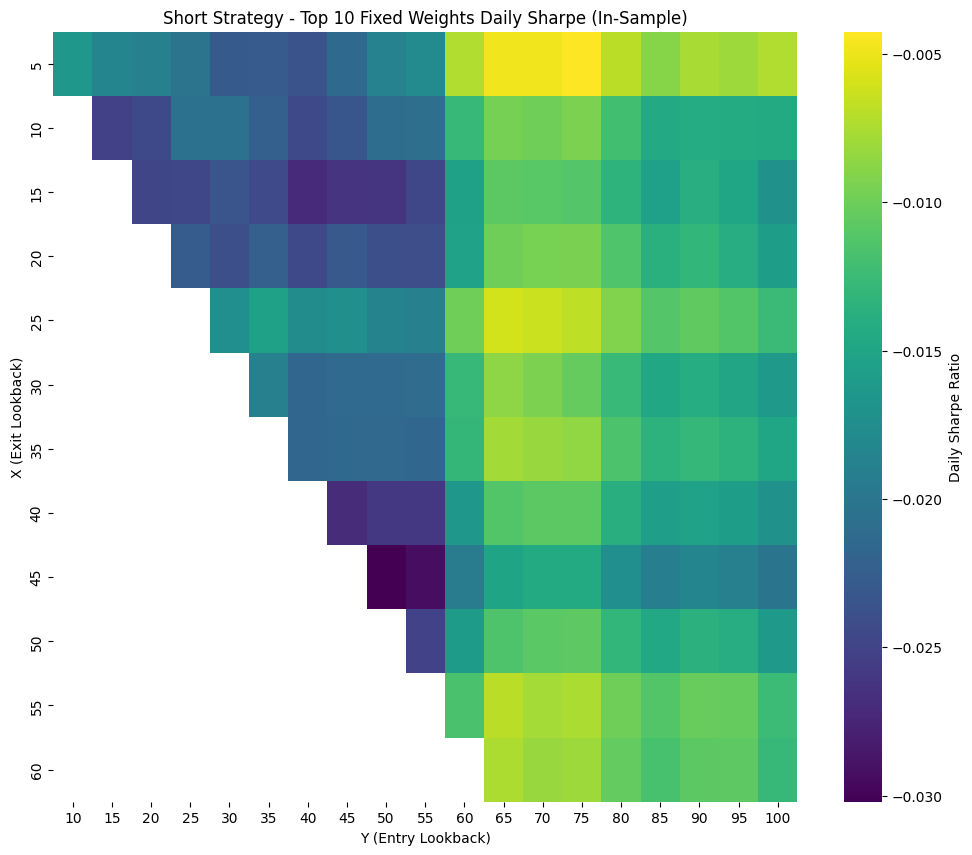

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(short_sharpe_matrix_fixed, xticklabels=Y_values, yticklabels=X_values, 
            cmap='viridis', annot=False, cbar_kws={'label': 'Daily Sharpe Ratio'})
plt.xlabel('Y (Entry Lookback)')
plt.ylabel('X (Exit Lookback)')
plt.title('Short Strategy - Top 10 Fixed Weights Daily Sharpe (In-Sample)')
plt.show()


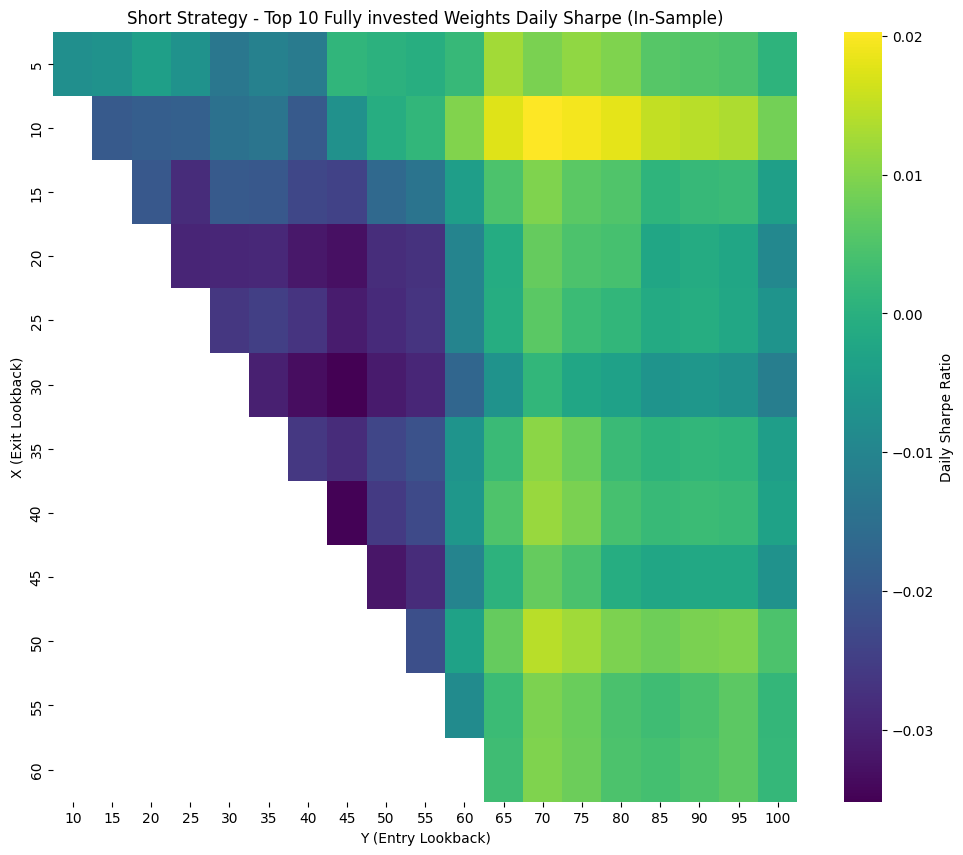

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(short_sharpe_matrix_invested, xticklabels=Y_values, yticklabels=X_values, 
            cmap='viridis', annot=False, cbar_kws={'label': 'Daily Sharpe Ratio'})
plt.xlabel('Y (Entry Lookback)')
plt.ylabel('X (Exit Lookback)')
plt.title('Short Strategy - Top 10 Fully invested Weights Daily Sharpe (In-Sample)')
plt.show()


### Optimization Results

We tested 240 parameter combinations across fixed-weight and fully-invested allocation methods on the 2020-2024 training period. Rather than selecting the single-best performing parameters (which risks overfitting), we analyzed the heatmap of Sharpe ratios to identify **stable, high-performing regions**.

#### Long vs. Short Strategy Analysis

We initially tested both long and short breakout strategies. However, the **short strategy consistently delivered negative Sharpe ratios** across all parameter combinations, except for a bit in the fully invested model but it is still not enough to justify shorts as shorting has additional costs (see short strategy heatmap). This finding reflects the structural upward bias in crypto markets during the test period — attempting to short breakouts resulted in losses as coins frequently continued rising after breaking below support levels.

**Decision**: All subsequent analysis focuses exclusively on **long-only strategies**. While this reduces the strategy's market-neutrality, it aligns with the momentum characteristics of crypto markets where upside breakouts are more reliable than downside failures.

**Selected Parameters**:
- **Entry Lookback (Y)**: 30 days
- **Exit Lookback (X)**: 5 days

In [45]:
train_sharpe_equal, _, _ = backtest_channel_breakout_with_mode(
    in_sample_prices,
    Y=30,
    X=5,
    mode='fixed'
)
print(f"Sharpe = {train_sharpe_equal * np.sqrt(365):.2f}")

Sharpe = 1.64


In [46]:
train_sharpe_fully, _, _ = backtest_channel_breakout_with_mode(
    in_sample_prices,
    Y=30,
    X=5,
    mode='fully_invested'
)
print(f"Sharpe = {train_sharpe_fully * np.sqrt(365):.2f}")

Sharpe = 1.56


In [47]:
sharpe_equal, returns_equal, weights_equal = backtest_channel_breakout_with_mode(
    out_of_sample_prices, 
    Y=30,
    X=5, 
    mode='fixed'
)

print(f"Sharpe = {sharpe_equal * np.sqrt(365):.2f}")


Sharpe = 2.17


In [48]:
sharpe_fully, returns_fully, weights_fully = backtest_channel_breakout_with_mode(
    out_of_sample_prices,
    Y=30,
    X=5,
    mode='fully_invested'
)

print(f"Sharpe = {sharpe_fully * np.sqrt(365):.2f}")

Sharpe = 1.38


#### Portfolio Construction Comparison

**Training Performance (In-Sample)**: Fixed-weight (1.64 Sharpe) and fully-invested (1.56 Sharpe) delivered similar results, with only a 5% difference.

**Test Performance (Out-of-Sample)**: Fixed-weight (2.17 Sharpe) significantly outperformed fully-invested (1.38 Sharpe), a **57% improvement**.

**Key Insight**: The **convergence in training but divergence in test** suggests that fully-invested allocation overfit to the 2020-2024 market conditions. When market dynamics shifted in the test period, the fixed-weight approach proved more robust. This pattern highlights the value of **capital preservation strategies** — holding cash during weak signal periods acted as a natural risk control that generalized better out-of-sample.

In [49]:
def compute_net_metrics(returns_df, weights_df, tcost_bps=20):

    # Calculate turnover
    turnover = (weights_df.fillna(0) - weights_df.shift().fillna(0)).abs().sum(axis=1)
    
    # Apply transaction costs
    net_returns = returns_df.subtract(turnover * tcost_bps * 1e-4, fill_value=0)
    
    # Compute metrics
    net_sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(365)
    net_annual_return = net_returns.mean() * 365
    net_max_dd = (net_returns.cumsum() - net_returns.cumsum().cummax()).min()
    net_win_rate = (net_returns > 0).sum() / len(net_returns)
    
    return {
        'sharpe': net_sharpe,
        'annual_return': net_annual_return,
        'max_dd': net_max_dd,
        'win_rate': net_win_rate,
        'turnover_mean': turnover.mean(),
        'net_returns' : net_returns
    }


In [50]:
metrics_equal = compute_net_metrics(returns_equal, weights_equal, tcost_bps=20)
metrics_invested = compute_net_metrics(returns_fully, weights_fully, tcost_bps=20)

In [51]:
print(f"Sharpe Ratio: {metrics_equal['sharpe']:.2f}")
print(f"Annual Return: {metrics_equal['annual_return']:.2%}")
print(f"Max Drawdown: {metrics_equal['max_dd']:.2%}")
print(f"Win Rate: {metrics_equal['win_rate']:.2%}")
print(f"Avg Turnover: {metrics_equal['turnover_mean']:.4f}")

Sharpe Ratio: 2.04
Annual Return: 56.90%
Max Drawdown: -17.18%
Win Rate: 29.74%
Avg Turnover: 0.0460


In [52]:
print(f"Sharpe Ratio: {metrics_invested['sharpe']:.2f}")
print(f"Annual Return: {metrics_invested['annual_return']:.2%}")
print(f"Max Drawdown: {metrics_invested['max_dd']:.2%}")
print(f"Win Rate: {metrics_invested['win_rate']:.2%}")
print(f"Avg Turnover: {metrics_invested['turnover_mean']:.4f}")

Sharpe Ratio: 1.09
Annual Return: 65.43%
Max Drawdown: -55.87%
Win Rate: 29.74%
Avg Turnover: 0.2292


### Final Performance: Transaction Cost-Adjusted Results

After optimizing for parameter selection and portfolio construction method, we calculate **net performance metrics** incorporating realistic trading costs. All returns are adjusted for 20 basis points (0.20%) per trade to reflect slippage and exchange fees typical in crypto markets.

The **fixed-weight strategy dominates** on all risk-adjusted metrics. It delivers strong returns (56.9%), exceptional Sharpe (2.04), and manageable risk (-17.2% drawdown) with reasonable trading costs. This makes it the clear choice for implementation.

### Extending to a Broader Universe: Top 80 Coins

Having established strong performance with the Top 10 coin universe (2.04 Sharpe, 56.9% return), we now test whether **expanding to a broader set of 80 cryptocurrencies** can further improve results through increased diversification.

**Motivation**: Academic research on crypto portfolio optimization suggests that diversifying across multiple cryptocurrencies can enhance Sharpe ratios and reduce concentration risk. While our Top 10 strategy focuses on the most liquid large-caps (Bitcoin, Ethereum, BNB, etc.), the Top 80 universe includes mid-cap altcoins that may offer additional momentum opportunities uncorrelated with major assets.

In [15]:
prices

,BTC,XRP,BNB,ADA,LINK,ZEC,TRX,LTC,PAXG,AVAX,...,CTC,KSM,ARPA,NMR,WAVES,PRO,ARK,ETH,SOL,DOGE
time,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15599.92,0.2458,27.72,0.09772,11.01,56.77,0.02500,59.00,1951.55,3.351,...,0.5479,30.50,0.01461,23.47,3.4300,0.08986,0.3019,414.07,1.41,0.002617
2020-11-06,15590.62,0.2589,29.05,0.10930,12.18,61.61,0.02615,63.36,1956.62,3.596,...,0.5443,32.55,0.01676,24.16,3.5660,0.08778,0.3240,454.72,1.91,0.002760
2020-11-07,14838.16,0.2494,27.78,0.10130,11.76,57.42,0.02495,58.98,1966.06,3.411,...,0.5593,31.22,0.01656,22.89,3.4380,0.07924,0.3030,435.71,2.03,0.002671
2020-11-08,15488.25,0.2538,28.42,0.10680,12.72,60.62,0.02536,61.00,1964.57,3.466,...,0.5842,32.99,0.01821,23.30,3.5180,0.08131,0.3361,453.55,2.16,0.002711
2020-11-09,15335.03,0.2506,28.11,0.10540,12.52,58.44,0.02485,59.24,1897.32,3.410,...,0.5913,33.26,0.01765,23.73,3.7900,0.08864,0.3582,444.16,2.03,0.002670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17,106485.41,2.2940,1072.31,0.62470,16.61,217.91,0.30900,90.15,4240.57,19.960,...,0.4313,10.50,0.02031,12.94,0.8476,0.55510,0.3205,3832.56,182.03,0.184842
2025-10-18,107228.76,2.3600,1092.66,0.63450,16.82,221.61,0.31300,91.72,4244.48,20.210,...,0.4447,10.55,0.02080,13.27,0.8364,0.55680,0.3217,3890.35,187.66,0.189599
2025-10-19,108701.79,2.3910,1110.93,0.65300,17.29,236.34,0.32050,93.34,4243.58,20.590,...,0.4526,10.95,0.02061,13.38,0.8457,0.57560,0.3294,3984.65,187.80,0.195323


In [16]:
returns_80 = prices.pct_change()

In [17]:
end_of_insample = pd.Timestamp('2024-08-31')
train_prices = prices.loc[:end_of_insample]
test_prices = prices.loc[end_of_insample:]
train_returns = returns_80.loc[:end_of_insample]
test_returns = returns_80.loc[end_of_insample:]

**Simplifying the Analysis**: Based on Top 10 results showing minimal difference between fixed-weight and fully-invested allocations, and shorts consistently delivering negative Sharpe ratios, we focus the Top 80 analysis exclusively on **fixed-weight, long-only strategies**. This streamlined approach efficiently tests whether broader diversification improves performance.

In [18]:
Y_values = range(10, 101, 5)
X_values = range(5, 61, 5)

long_sharpe_matrix_fixed_80 = np.zeros((len(X_values), len(Y_values)))

for i, Y in enumerate(Y_values):
    for j, X in enumerate(X_values):
        if X < Y:
            # Fixed-weight mode
            daily_sharpe_fixed_80, _, _ = backtest_channel_breakout_with_mode(
                train_prices,
                Y=Y,
                X=X,
                mode='fixed'
            )
            long_sharpe_matrix_fixed_80[j, i] = daily_sharpe_fixed_80
            
        else:
            long_sharpe_matrix_fixed_80[j, i] = np.nan
            

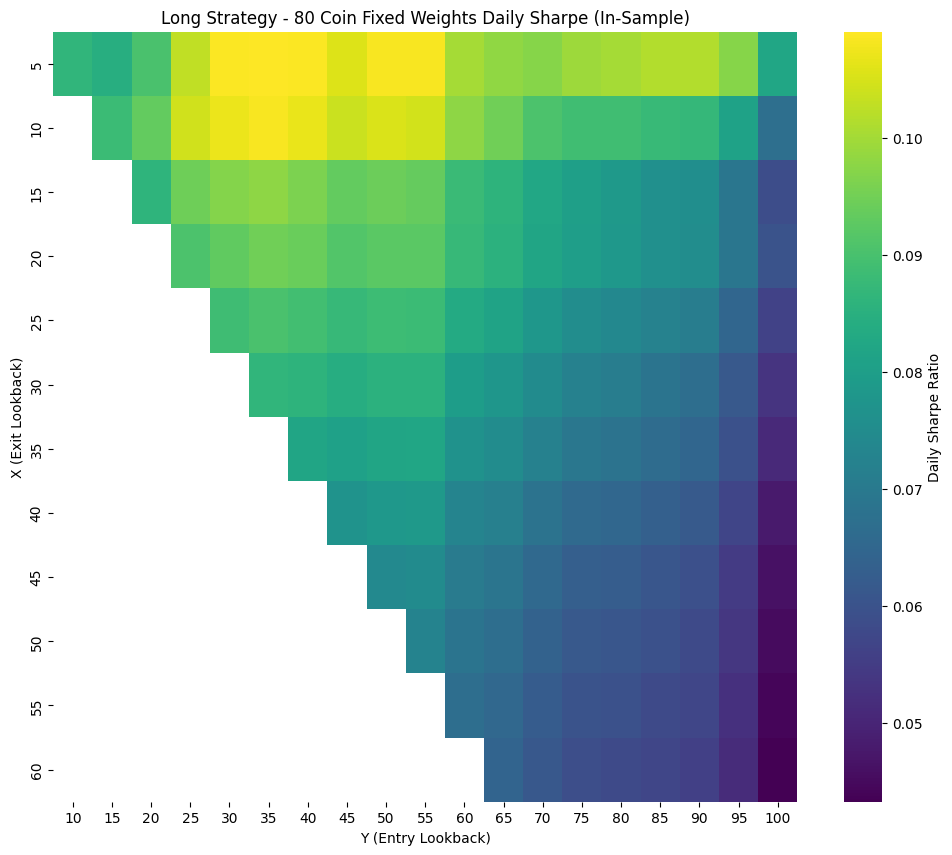

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(long_sharpe_matrix_fixed_80, xticklabels=Y_values, yticklabels=X_values, 
            cmap='viridis', annot=False, cbar_kws={'label': 'Daily Sharpe Ratio'})
plt.xlabel('Y (Entry Lookback)')
plt.ylabel('X (Exit Lookback)')
plt.title('Long Strategy - 80 Coin Fixed Weights Daily Sharpe (In-Sample)')
plt.show()


### Top 80 Optimization Results

The parameter heatmap for the 80-coin universe reveals a different performance landscape compared to Top 10. The brightest regions (highest Sharpe) appear in the **upper-left quadrant** similar to the top 10 performance however it is much clearer, around Y=20-40 and X=5-15, indicating that shorter-to-medium lookback periods work best with the expanded universe.

**Selected Parameters**:
- **Entry Lookback (Y)**: 35 days
- **Exit Lookback (X)**: 5 days

In [53]:
train_sharpe_equal_80, _, _ = backtest_channel_breakout_with_mode(
    train_prices,
    Y=35,
    X=5,
    mode='fixed'
)
print(f"Sharpe = {train_sharpe_equal_80 * np.sqrt(365):.2f}")

Sharpe = 2.08


In [54]:
train_sharpe_fully_80, _, _ = backtest_channel_breakout_with_mode(
    train_prices,
    Y=35,
    X=5,
    mode='fully_invested'
)
print(f"Sharpe = {train_sharpe_fully_80 * np.sqrt(365):.2f}")

Sharpe = 1.58


In [55]:
sharpe_equal_80, returns_equal_80, weights_equal_80 = backtest_channel_breakout_with_mode(
    test_prices, 
    Y=35,
    X=5, 
    mode='fixed'
)

print(f"Sharpe = {sharpe_equal_80 * np.sqrt(365):.2f}")

Sharpe = 1.54


In [56]:
sharpe_fully_80, returns_fully_80, weights_fully_80 = backtest_channel_breakout_with_mode(
    test_prices,
    Y=35,
    X=5,
    mode='fully_invested'
)

print(f"Sharpe = {sharpe_fully_80 * np.sqrt(365):.2f}")

Sharpe = 0.73


Similarly to the top 10 performance the fixed weight portfolio outperforms fully invested, however out of sample results on the equal weighted portfolio were worst than in sample. This is not necessearily a bad thing as some sharpe degredation is expected. Now we might ask the question is it a problem that the top 10 equally weighted portfolio significantly outperformed in sample. In this case id argue its not since the in sample contained different market conditions so its not just a case of experiencing unusal market conditions thorughout the out of sample time period that wouldn't represent typical performance

In [57]:
metrics_equal_80 = compute_net_metrics(returns_equal_80, weights_equal_80, tcost_bps=20)
metrics_invested_80 = compute_net_metrics(returns_fully_80, weights_fully_80, tcost_bps=20)

In [58]:
print(f"Sharpe Ratio: {metrics_equal_80['sharpe']:.2f}")
print(f"Annual Return: {metrics_equal_80['annual_return']:.2%}")
print(f"Max Drawdown: {metrics_equal_80['max_dd']:.2%}")
print(f"Win Rate: {metrics_equal_80['win_rate']:.2%}")
print(f"Avg Turnover: {metrics_equal_80['turnover_mean']:.4f}") 

Sharpe Ratio: 1.45
Annual Return: 38.53%
Max Drawdown: -18.98%
Win Rate: 43.65%
Avg Turnover: 0.0299


In [59]:
print(f"Sharpe Ratio: {metrics_invested_80['sharpe']:.2f}")
print(f"Annual Return: {metrics_invested_80['annual_return']:.2%}")
print(f"Max Drawdown: {metrics_invested_80['max_dd']:.2%}")
print(f"Win Rate: {metrics_invested_80['win_rate']:.2%}")
print(f"Avg Turnover: {metrics_invested_80['turnover_mean']:.4f}")

Sharpe Ratio: 0.42
Annual Return: 34.78%
Max Drawdown: -113.46%
Win Rate: 43.65%
Avg Turnover: 0.3506


### Top 80 Universe Results

The fully-invested approach produces a catastrophic **-113% drawdown**, exceeding total portfolio wipeout. By forcing 100% capital deployment across few active signals, it creates extreme position concentration that amplifies losses during reversals. The Sharpe ratio gap (1.45 vs 0.42) confirms fixed-weight's massive risk-adjusted advantage.

**Cash is insurance, not drag.** Holding idle capital during weak signal periods prevents the forced concentration that destroyed the fully-invested strategy—despite identical win rates (43.65%).

Comparing Top 80 (1.45 Sharpe, 38.53%) vs Top 10 (2.04 Sharpe, 56.9%) shows **universe expansion degrades performance**. Adding 70 mid-cap coins introduces lower liquidity, correlated moves, and weaker signals without genuine diversification benefits.

In [60]:
benchmark_returns = test_returns['BTC']
cum_equal = returns_equal.cumsum()
cum_fully = returns_fully.cumsum()
cum_equal_80 = returns_equal_80.cumsum()
cum_fully_80 = returns_fully_80.cumsum()
cum_btc = benchmark_returns.cumsum()

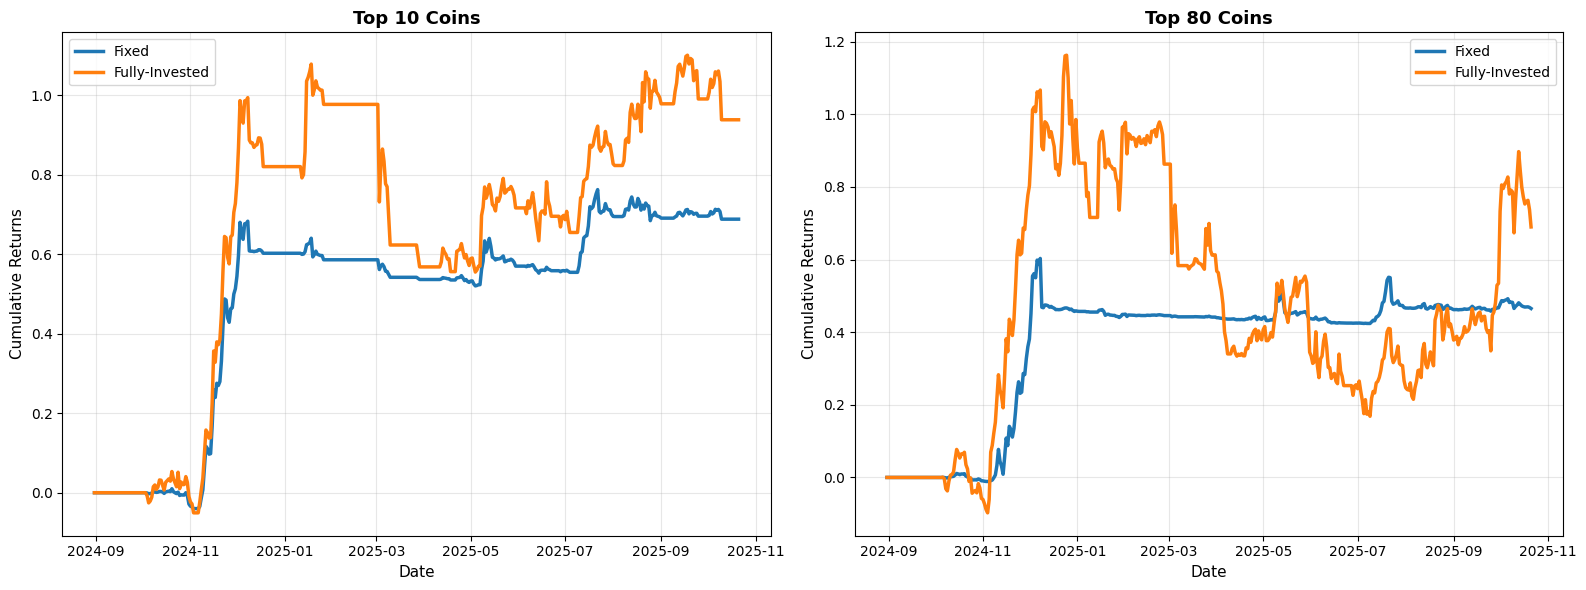

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10
ax1.plot(cum_equal.index, cum_equal.values, label='Fixed', linewidth=2.5, color='#1f77b4')
ax1.plot(cum_fully.index, cum_fully.values, label='Fully-Invested', linewidth=2.5, color='#ff7f0e')
ax1.set_title('Top 10 Coins', fontsize=13, fontweight='bold')
ax1.set_ylabel('Cumulative Returns', fontsize=11)
ax1.set_xlabel('Date', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Top 80
ax2.plot(cum_equal_80.index, cum_equal_80.values, label='Fixed', linewidth=2.5, color='#1f77b4')
ax2.plot(cum_fully_80.index, cum_fully_80.values, label='Fully-Invested', linewidth=2.5, color='#ff7f0e')
ax2.set_title('Top 80 Coins', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Returns', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Chosing the best strategy based on highest sharpe to plot against Bitcoin returns

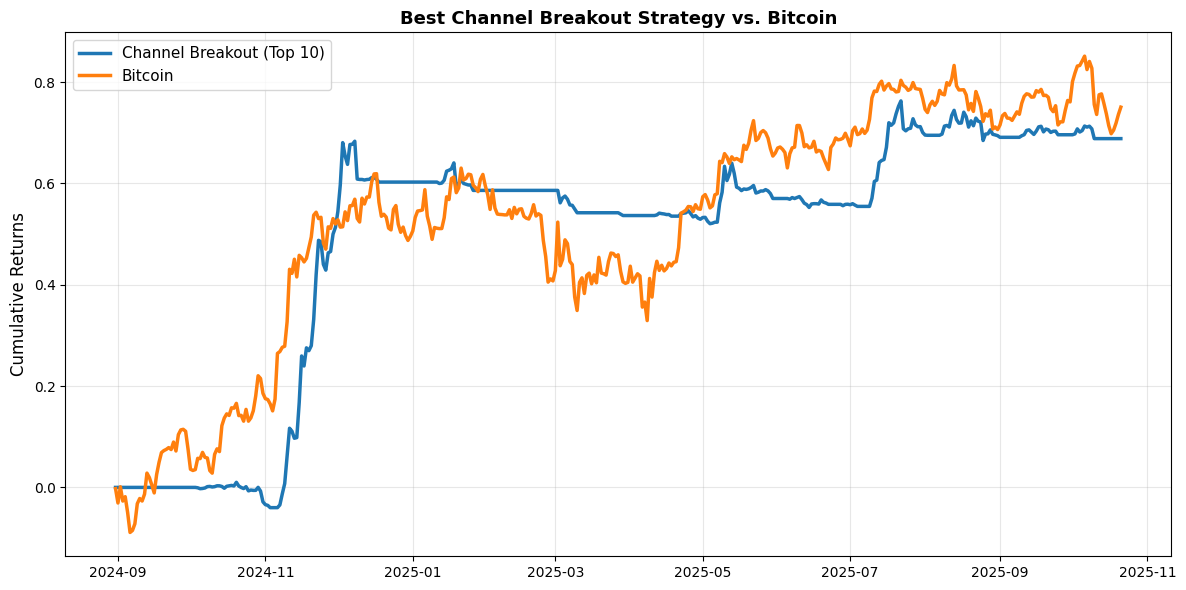

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(cum_equal.index, cum_equal.values, label='Channel Breakout (Top 10)', linewidth=2.5)
plt.plot(cum_btc.index, cum_btc.values, label='Bitcoin',linewidth=2.5 )
plt.ylabel('Cumulative Returns', fontsize=12)
plt.title('Best Channel Breakout Strategy vs. Bitcoin', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [63]:
def compute_alpha_beta_metrics(strategy_returns, benchmark_returns):
   
    # Align the series
    aligned = pd.DataFrame({
        'strategy': strategy_returns,
        'benchmark': benchmark_returns
    }).dropna()
    
    X = aligned['benchmark']
    X = sm.add_constant(X)  
    Y = aligned['strategy']
    
    results = sm.OLS(Y, X).fit()
    
    alpha_daily = results.params['const']
    beta = results.params['benchmark']
    alpha_tstat = results.tvalues['const']
    
    alpha_annual = alpha_daily * 365
    
    # Information Ratio = (excess return) / tracking error
    tracking_error = results.resid.std() * np.sqrt(365)
    excess_annual_return = alpha_annual
    
    if tracking_error != 0:
        info_ratio = excess_annual_return / tracking_error
    else:
        info_ratio = 0
    
    return {
        'alpha_annual': alpha_annual,
        'beta': beta,
        'alpha_tstat': alpha_tstat,
        'info_ratio': info_ratio
    }

# Calculate for all 4
stats_equal = compute_alpha_beta_metrics(metrics_equal['net_returns'], benchmark_returns)
stats_fully = compute_alpha_beta_metrics(metrics_invested['net_returns'], benchmark_returns)
stats_equal_80 = compute_alpha_beta_metrics(metrics_equal_80['net_returns'], benchmark_returns)
stats_fully_80 = compute_alpha_beta_metrics(metrics_invested_80['net_returns'], benchmark_returns)

# Create results table
results_df = pd.DataFrame([
    {'Strategy': 'Top 10 (Fixed)', **stats_equal},
    {'Strategy': 'Top 10 (Fully-Invested)', **stats_fully},
    {'Strategy': 'Top 80 (Fixed)', **stats_equal_80},
    {'Strategy': 'Top 80 (Fully-Invested)', **stats_fully_80}
])

print(results_df.to_string(index=False))


               Strategy  alpha_annual     beta  alpha_tstat  info_ratio
         Top 10 (Fixed)      0.434997 0.203955     1.755785    1.649667
Top 10 (Fully-Invested)      0.244340 0.623936     0.488326    0.458812
         Top 80 (Fixed)      0.290024 0.145067     1.195613    1.123351
Top 80 (Fully-Invested)     -0.243541 0.900066    -0.357499   -0.335892


### Alpha and Beta Analysis: Statistical Validation

To confirm whether our strategies generate genuine alpha or simply capture Bitcoin beta exposure, we regress each strategy's returns against Bitcoin using OLS.

**Top 10 Fixed delivers the strongest alpha**: With 43.5% annual alpha and a t-stat of 1.76, this configuration generates meaningful excess returns. The low beta of 0.20 confirms returns come from strategy skill rather than Bitcoin exposure.

**Fully-invested approaches destroy alpha**: The Top 10 Fully-Invested strategy's alpha drops to 24.4% with a t-stat of just 0.48 (statistically insignificant), while Top 80 Fully-Invested produces **negative alpha** of -24.35%. Their higher betas (0.62 and 0.91) suggest they primarily capture market exposure without adding genuine skill-based returns.

**Information Ratio confirms quality**: The Top 10 Fixed strategy's IR of 1.65 (alpha per unit of idiosyncratic risk) substantially exceeds the other configurations. An IR above 0.5 is considered good; 1.65 is exceptional. Fully-invested approaches produce near-zero or negative IRs, indicating they add no value after accounting for risk.

In [64]:
def compute_complete_metrics(returns_df, weights_df, benchmark_returns, tcost_bps=20):
   
    # Calculate turnover
    turnover = (weights_df.fillna(0) - weights_df.shift().fillna(0)).abs().sum(axis=1)
    
    # Apply transaction costs
    net_returns = returns_df.subtract(turnover * tcost_bps * 1e-4, fill_value=0)
    
    # Basic metrics
    annual_return = net_returns.mean() * 365
    volatility = net_returns.std() * np.sqrt(365)
    sharpe_ratio = (net_returns.mean() / net_returns.std()) * np.sqrt(365)
    hit_rate = (net_returns > 0).sum() / len(net_returns)
    
    # Drawdown
    cumulative = net_returns.cumsum()
    running_max = cumulative.cummax()
    drawdown = cumulative - running_max
    max_drawdown = drawdown.min()
    
    # Max drawdown duration
    is_drawdown = drawdown < 0
    drawdown_periods = is_drawdown.astype(int).groupby((is_drawdown != is_drawdown.shift()).cumsum()).sum()
    max_dd_duration = drawdown_periods.max() if len(drawdown_periods) > 0 else 0
    
    # Holding period 
    in_position = (weights_df.sum(axis=1) > 0).astype(int)
    position_changes = (in_position != in_position.shift()).cumsum()
    position_durations = in_position.groupby(position_changes).sum()
    avg_holding_period = position_durations[position_durations > 0].mean()
    
    # Alpha/Beta regression
    aligned = pd.DataFrame({
        'strategy': net_returns,
        'benchmark': benchmark_returns
    }).dropna()

    correlation = aligned['strategy'].corr(aligned['benchmark'])
    
    X = aligned['benchmark']
    X = sm.add_constant(X)
    Y = aligned['strategy']
    results = sm.OLS(Y, X).fit()
    
    alpha_daily = results.params['const']
    beta = results.params['benchmark']
    alpha_tstat = results.tvalues['const']
    
    # Information Ratio
    tracking_error = results.resid.std() * np.sqrt(365)
    info_ratio = (alpha_daily * 365) / tracking_error if tracking_error != 0 else 0
    
    return {
        'Return (Ann.)': f"{annual_return:.2%}",
        'Volatility (Ann.)': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Hit Rate': f"{hit_rate:.2%}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Max DD Duration': f"{max_dd_duration:.0f} days",
        'Holding Period': f"{avg_holding_period:.2f} days",
        'Correlation to BTC': f"{correlation:.2f}",
        'Information Ratio': f"{info_ratio:.2f}",
        'Alpha (Ann.)': f"{alpha_daily * 365:.2%}",
        'Alpha t-stat': f"{alpha_tstat:.2f}",
        'Beta': f"{beta:.2f}"
    }

best_performer = compute_complete_metrics(
    returns_equal, 
    weights_equal, 
    benchmark_returns, 
    tcost_bps=20
)

print("=" * 40)
print("Top 10 Coins (Fixed Weight) - Strategy Metrics")
print("=" * 40)
for key, value in best_performer.items():
    print(f"{key:25} {value}")


Top 10 Coins (Fixed Weight) - Strategy Metrics
Return (Ann.)             56.90%
Volatility (Ann.)         27.86%
Sharpe Ratio              2.04
Hit Rate                  29.74%
Max Drawdown              -17.18%
Max DD Duration           220 days
Holding Period            17.21 days
Correlation to BTC        0.32
Information Ratio         1.65
Alpha (Ann.)              43.50%
Alpha t-stat              1.76
Beta                      0.20


## Part 2: Sentiment Analysis Strategy

### Strategy Rationale

While the Channel Breakout strategy exploits price momentum, the sentiment strategy captures a different alpha source: **retail crowd psychology**. Cryptocurrency markets are uniquely susceptible to social sentiment—a single tweet or trending topic can drive substantial price movements. This strategy hypothesizes that changes in retail search interest, as measured by Google Trends, predict short-term price momentum.

### Why Google Trends?

Unlike traditional sentiment sources (Twitter, Reddit), Google Trends captures **active information-seeking behavior** rather than passive social media chatter. When retail investors search for a cryptocurrency by name, it signals genuine interest that often precedes capital deployment. Google Trends data is:
- **Quantitative**: Provides normalized search volume (0-100 scale)
- **Unbiased**: Reflects actual search behavior, not bot-manipulated social metrics
- **Leading**: Search spikes often occur before or during price rallies as FOMO builds

### Signal Construction Logic

We test three hypotheses about how search volume relates to future returns:

1. **Momentum Hypothesis**: High absolute search volume → Bullish (retail FOMO drives prices higher)
2. **Contrarian Hypothesis**: High absolute search volume → Bearish (retail buying at tops, contrarian fade)
3. **Delta Hypothesis**: Increasing search volume (week-over-week change) → Bullish (acceleration in interest precedes moves)

In [23]:
trends_df = pd.read_csv('5_coins_google_trends.csv', index_col=0, parse_dates=True)

In [24]:
prices_weekly = prices.resample('W-SUN').last()
returns_1w = prices_weekly.pct_change(1).shift(-1)
returns_weekly = prices_weekly.pct_change()

In [25]:
top_5 = ['BTC', 'ETH', 'SOL', 'ADA', 'DOGE']
returns_weekly = returns_weekly[top_5]
trends_weekly = trends_df[top_5]

In [26]:
split_date = pd.Timestamp('2024-08-31')
returns_train_5 = returns_weekly.loc[:split_date]
returns_test_5 = returns_weekly.loc[split_date:]
trends_train_5 = trends_weekly.loc[:split_date]
trends_test_5 = trends_weekly.loc[split_date:]

In [65]:
def test_momentum_hypothesis(trends_df, returns_df, threshold=80):
    
    results = {}
    
    for coin in trends_df.columns:
        # Calculate percentile rank
        percentile = trends_df[coin].rank(pct=True) * 100
        
        # Identify spikes (top 20% by default)
        is_spike = percentile >= threshold
        
        # Get returns after spikes vs normal periods
        spike_returns = returns_df[coin][is_spike].dropna()
        normal_returns = returns_df[coin][~is_spike].dropna()
        
        results[coin] = {
            'spike_mean': spike_returns.mean(),
            'normal_mean': normal_returns.mean(),
            'spike_median': spike_returns.median(),
            'difference': spike_returns.mean() - normal_returns.mean(),
            't_stat': stats.ttest_ind(spike_returns, normal_returns)[0],
            'p_value': stats.ttest_ind(spike_returns, normal_returns)[1]
        }
    
    return pd.DataFrame(results).T

In [66]:
def test_contrarian_zscore(trends_df, returns_df, z_threshold=1.5):
    
    results = {}
    
    for coin in trends_df.columns:
        # Calculate z-score
        z_score = (trends_df[coin] - trends_df[coin].mean()) / trends_df[coin].std()
        
        # Identify extremes 
        is_extreme = z_score >= z_threshold
        
        # Create aligned dataframe with both is_extreme and returns
        aligned_df = pd.DataFrame({
            'is_extreme': is_extreme,
            'return': returns_df[coin]
        }).dropna()
        
        # Split based on extreme flag
        extreme_returns = aligned_df[aligned_df['is_extreme']]['return']
        normal_returns = aligned_df[~aligned_df['is_extreme']]['return']
        
        if len(extreme_returns) > 10 and len(normal_returns) > 10:  # Ensure sufficient data
            results[coin] = {
                'extreme_mean': extreme_returns.mean(),
                'normal_mean': normal_returns.mean(),
                'extreme_median': extreme_returns.median(),
                'difference': extreme_returns.mean() - normal_returns.mean(),
                't_stat': stats.ttest_ind(extreme_returns, normal_returns)[0],
                'p_value': stats.ttest_ind(extreme_returns, normal_returns)[1],
                'n_extreme': len(extreme_returns),
                'n_normal': len(normal_returns)
            }
        else:
            results[coin] = {
                'extreme_mean': np.nan,
                'normal_mean': np.nan,
                'extreme_median': np.nan,
                'difference': np.nan,
                't_stat': np.nan,
                'p_value': np.nan,
                'n_extreme': len(extreme_returns),
                'n_normal': len(normal_returns)
            }
    
    return pd.DataFrame(results).T

In [67]:
def test_delta_hypothesis(trends_df, returns_df):
   
    results = {}
    
    for coin in trends_df.columns:
        # Calculate week-over-week change
        delta = trends_df[coin].pct_change()
        
        # Align delta with forward returns
        aligned = pd.DataFrame({
            'delta': delta,
            'return': returns_df[coin]
        }).dropna()
        
        # Correlation
        correlation = aligned.corr().iloc[0, 1]
        
        # Rank correlation (Spearman)
        spearman = stats.spearmanr(aligned['delta'], aligned['return'])
        
        # Quintile analysis
        aligned['delta_quintile'] = pd.qcut(aligned['delta'], 5, labels=False, duplicates='drop')
        quintile_returns = aligned.groupby('delta_quintile')['return'].mean()
        
        results[coin] = {
            'pearson_corr': correlation,
            'spearman_corr': spearman[0],
            'spearman_pval': spearman[1],
            'Q1_return': quintile_returns.iloc[0] if len(quintile_returns) > 0 else np.nan,
            'Q5_return': quintile_returns.iloc[-1] if len(quintile_returns) > 0 else np.nan,
            'Q5_minus_Q1': (quintile_returns.iloc[-1] - quintile_returns.iloc[0]) if len(quintile_returns) > 1 else np.nan
        }
    
    return pd.DataFrame(results).T

In [68]:
momentum_1w = test_momentum_hypothesis(trends_df, returns_1w, threshold=80)
print("\n=== MOMENTUM HYPOTHESIS (1-week forward) ===")
print(momentum_1w)


=== MOMENTUM HYPOTHESIS (1-week forward) ===
      spike_mean  normal_mean  spike_median  difference    t_stat   p_value
BTC     0.011475     0.010797      0.013029    0.000677  0.054087  0.956908
ETH     0.023298     0.012159      0.033056    0.011139  0.651135  0.515541
SOL     0.011819     0.036424     -0.014722   -0.024605 -0.919713  0.358585
ADA     0.034258     0.013008      0.002108    0.021249  0.902806  0.367474
DOGE    0.172493     0.013256      0.010322    0.159237  3.014835  0.002829


In [69]:
delta_1w = test_delta_hypothesis(trends_df, returns_1w)
print("\n=== DELTA HYPOTHESIS (1-week forward) ===")
print(delta_1w)


=== DELTA HYPOTHESIS (1-week forward) ===
      pearson_corr  spearman_corr  spearman_pval  Q1_return  Q5_return  \
BTC       0.033868       0.079731   2.009027e-01   0.008616   0.031476   
ETH       0.313104       0.278867   5.189932e-06  -0.007531   0.092837   
SOL       0.162405       0.242674   7.956086e-05  -0.008465   0.122724   
ADA       0.460091       0.398960   2.583660e-11  -0.035291   0.163411   
DOGE      0.813445       0.356767   3.432481e-09  -0.047703   0.272045   

      Q5_minus_Q1  
BTC      0.022860  
ETH      0.100368  
SOL      0.131189  
ADA      0.198702  
DOGE     0.319748  


In [70]:
contrarian_1w = test_contrarian_zscore(trends_df, returns_1w, z_threshold=1.5)
print("\n=== CONTRARIAN HYPOTHESIS (1-week forward, z-score=1.5) ===")
print(contrarian_1w)


=== CONTRARIAN HYPOTHESIS (1-week forward, z-score=1.5) ===
      extreme_mean  normal_mean  extreme_median  difference    t_stat  \
BTC       0.010973     0.010932        0.035946    0.000041  0.002246   
ETH       0.052847     0.011351        0.068491    0.041496  1.585122   
SOL       0.057390     0.029317        0.036546    0.028074  0.698805   
ADA       0.091563     0.011236        0.095136    0.080327  2.261231   
DOGE      0.690859     0.012571        0.271812    0.678289  7.403719   

           p_value  n_extreme  n_normal  
BTC   9.982097e-01       22.0     237.0  
ETH   1.141683e-01       19.0     240.0  
SOL   4.853060e-01       20.0     239.0  
ADA   2.458135e-02       20.0     239.0  
DOGE  1.892978e-12       12.0     247.0  


### Sentiment Strategy Backtest Function

Based on the findings The delta approach proves superior because it captures **sentiment shifts** rather than levels. A coin with sustained high search volume (like Bitcoin) may be range-bound, but a coin experiencing a sudden search surge often enters a momentum phase.

**Logic**: For each coin, calculate the percentage change in search volume over the lookback period. Rank these deltas across all time periods (0 to 1 scale), then generate a binary signal (1 = long, 0 = no position) when the rank exceeds the threshold.

**Example**: With threshold=0.6, only weeks where a coin's delta ranks in the top 40% trigger a long signal. This filters for coins experiencing significant search acceleration relative to their historical patterns.


In [21]:
def delta_strategy_parameterized(trends_df, returns_df, threshold=0.6, lookback=1, mode='fixed'):

    # Generate delta signals
    signals = pd.DataFrame(0, index=trends_df.index, columns=trends_df.columns)
    
    for coin in trends_df.columns:
        delta = trends_df[coin].pct_change(lookback)
        delta_rank = delta.rank(pct=True)
        signals[coin] = (delta_rank > threshold).astype(int)
    
    # Calculate weights based on mode
    num_coins = len(trends_df.columns)
    weights = pd.DataFrame(0.0, index=signals.index, columns=signals.columns)
    
    if mode == 'fixed':
        # Fixed weight
        fixed_weight = 1.0 / num_coins
        weights = signals * fixed_weight
    
    elif mode == 'fully_invested':
        # Fully invested
        for period in signals.index:
            num_signals = signals.loc[period].sum()
            if num_signals > 0:
                weights.loc[period] = signals.loc[period] / num_signals
            else:
                weights.loc[period] = 0
    
    # Calculate portfolio returns
    strategy_returns = (weights.shift(1) * returns_df).sum(axis=1)
    
    return strategy_returns, signals, weights


### Parameter Optimization via Grid Search

To find the optimal configuration for the sentiment strategy, we implement a **grid search** across three key parameters:

#### Parameter Grid

 thresholds = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80] 
 
 lookbacks =​​ [1, 2, 3]
 
 modes = ['fixed', 'fully_invested']

- **threshold**: Percentile cutoff for signal generation (30th to 80th percentile)
- **lookback**: Number of weeks to calculate delta in search volume
- **mode**: Portfolio allocation method

This creates 36 total combinations (6 thresholds × 3 lookbacks × 2 modes) 

In [28]:
import itertools

thresholds = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
lookbacks = [1, 2, 3]
modes = ['fixed', 'fully_invested']

results = []

for threshold, lookback, mode in itertools.product(thresholds, lookbacks, modes):
    # Out-of-sample test
    strat_returns, _, _ = delta_strategy_parameterized(
        trends_train_5, returns_train_5, threshold, lookback, mode=mode
    )
    
    # Calculate metrics
    sharpe = (strat_returns.mean() / strat_returns.std()) * np.sqrt(52)
    annual_return = strat_returns.mean() * 52
    max_dd = (strat_returns.cumsum() - strat_returns.cumsum().cummax()).min()
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    results.append({
        'threshold': threshold,
        'lookback': lookback,
        'mode': mode,
        'sharpe': sharpe,
        'return': annual_return,
        'max_dd': max_dd,
        'win_rate': win_rate
    })

results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)

print("TOP PARAMETER COMBINATIONS:")
print(results_df.head(20)[['threshold', 'lookback', 'mode', 'sharpe', 'return', 'max_dd']].to_string(index=False))

TOP PARAMETER COMBINATIONS:
 threshold  lookback           mode   sharpe   return    max_dd
       0.7         1          fixed 2.138941 1.510951 -0.350630
       0.8         1          fixed 2.076689 1.399421 -0.307737
       0.6         1          fixed 2.061864 1.489621 -0.581799
       0.6         2          fixed 1.992410 1.484344 -0.474321
       0.8         2          fixed 1.982019 1.339960 -0.317450
       0.7         2          fixed 1.971726 1.439276 -0.440748
       0.5         1          fixed 1.939347 1.603367 -0.686992
       0.5         2          fixed 1.921003 1.650212 -0.668097
       0.4         1          fixed 1.816083 1.532635 -0.736843
       0.3         1          fixed 1.800167 1.562477 -0.716389
       0.4         2          fixed 1.780768 1.564922 -0.840551
       0.7         3          fixed 1.780742 1.332920 -0.709527
       0.8         1 fully_invested 1.702970 3.319893 -0.497695
       0.8         3          fixed 1.682471 1.172040 -0.541586
       0.6  

Here we can see that fixed weights have higher sharpe but since fully invested has a significantly higher return we will test both on out of sample. However they have different thresholds as to where they perform best but the differences are not that big therefore we are going to use 0.7 and 1 on our test data

In [29]:
test_returns_delta, _, weights_delta = delta_strategy_parameterized(
    trends_test_5,
    returns_test_5,
    threshold=0.7,
    lookback=1,
    mode='fixed'
)

In [30]:
test_returns_delta_fully, _, weights_delta_fully = delta_strategy_parameterized(
    trends_test_5,
    returns_test_5,
    threshold=0.7,
    lookback=1,
    mode='fully_invested'
)

In [31]:
def compute_net_metrics_weekly(returns_df, weights_df, tcost_bps=20):

    # Calculate turnover
    turnover = (weights_df.fillna(0) - weights_df.shift().fillna(0)).abs().sum(axis=1)
    
    # Apply transaction costs
    net_returns = returns_df.subtract(turnover * tcost_bps * 1e-4, fill_value=0)
    
    # Compute metrics
    net_sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(52)
    net_annual_return = net_returns.mean() * 52
    net_max_dd = (net_returns.cumsum() - net_returns.cumsum().cummax()).min()
    net_win_rate = (net_returns > 0).sum() / len(net_returns)
    
    return {
        'sharpe': net_sharpe,
        'annual_return': net_annual_return,
        'max_dd': net_max_dd,
        'win_rate': net_win_rate,
        'turnover_mean': turnover.mean(),
        'net_returns' : net_returns
    }

In [32]:
delta_net = compute_net_metrics_weekly(test_returns_delta, weights_delta, tcost_bps=20)
delta_fully_net = compute_net_metrics_weekly(test_returns_delta_fully, weights_delta_fully, tcost_bps=20)

In [33]:
print(f"Sharpe Ratio: {delta_net['sharpe']:.2f}")
print(f"Annual Return: {delta_net['annual_return']:.2%}")
print(f"Max Drawdown: {delta_net['max_dd']:.2%}")
print(f"Win Rate: {delta_net['win_rate']:.2%}")
print(f"Avg Turnover: {delta_net['turnover_mean']:.4f}") 

Sharpe Ratio: 2.43
Annual Return: 132.93%
Max Drawdown: -17.94%
Win Rate: 33.87%
Avg Turnover: 0.3903


In [34]:
print(f"Sharpe Ratio: {delta_fully_net['sharpe']:.2f}")
print(f"Annual Return: {delta_fully_net['annual_return']:.2%}")
print(f"Max Drawdown: {delta_fully_net['max_dd']:.2%}")
print(f"Win Rate: {delta_fully_net['win_rate']:.2%}")
print(f"Avg Turnover: {delta_fully_net['turnover_mean']:.4f}") 

Sharpe Ratio: 1.98
Annual Return: 161.35%
Max Drawdown: -69.97%
Win Rate: 33.87%
Avg Turnover: 0.9312


### Net Out-of-Sample Results: Fixed vs Fully-Invested

The fixed-weight approach delivers exceptional risk-adjusted returns with a **2.43 Sharpe ratio**—far exceeding the 1.0 threshold for strong strategies. The 132.93% annual return demonstrates powerful alpha generation from Google Trends signals, while the modest -17.94% drawdown shows disciplined risk management. The 33.87% win rate is typical for momentum strategies, where profits come from large winners rather than frequent small gains.

While the fully-invested approach generates higher raw returns (161.35%), it produces a **catastrophic -69.97% drawdown** that nearly wipes out the portfolio. This extreme risk destroys the strategy's viability despite higher nominal returns. The Sharpe ratio drops to 1.98, and turnover more than doubles (0.93 vs 0.39), indicating forced concentration and excessive rebalancing.

### Extending to a Broader Universe: 20 Coins

Similarly to the channel breakout strategy we are going to test whether performance can be improved by testing on more coins. Out of the 20 coins, 10 are large fundamental and 10 are meme/alt coins to make sure we have a diversified universe

In [35]:
google_trends_df = pd.read_csv('google_trends_20coins_combined.csv', index_col=0, parse_dates=True)
google_trends_df.index = pd.to_datetime(google_trends_df.index, format='%d/%m/%Y')

In [36]:
coins_20 = [
    'BTC', 'ETH', 'BNB', 'SOL', 'ADA', 
    'AVAX', 'DOT', 'LINK', 'UNI', 'XRP',
    'DOGE', 'FET', 'NEAR', 'HBAR', 'INJ',
    'LPT', 'IOTX', 'KDA', 'CRV', 'KSM'
]

prices_20 = prices[coins_20]

In [37]:
prices_weekly_20 = prices_20.resample('W-SUN').last()
returns_weekly_20 = prices_weekly.pct_change()


In [38]:
split_date = pd.Timestamp('2024-08-31')
returns_train_20 = returns_weekly_20.loc[:split_date]
returns_test_20= returns_weekly_20.loc[split_date:]
trends_train_20 = google_trends_df.loc[:split_date]
trends_test_20 = google_trends_df.loc[split_date:]

In [39]:
thresholds = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
lookbacks = [1, 2, 3]
modes = ['fixed', 'fully_invested']

results = []

for threshold, lookback, mode in itertools.product(thresholds, lookbacks, modes):
    
    strat_returns, _, _ = delta_strategy_parameterized(
        trends_train_20, returns_train_20, threshold, lookback, mode=mode
    )
    
    # Calculate metrics
    sharpe = (strat_returns.mean() / strat_returns.std()) * np.sqrt(52)
    annual_return = strat_returns.mean() * 52
    max_dd = (strat_returns.cumsum() - strat_returns.cumsum().cummax()).min()
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    results.append({
        'threshold': threshold,
        'lookback': lookback,
        'mode': mode,
        'sharpe': sharpe,
        'return': annual_return,
        'max_dd': max_dd,
        'win_rate': win_rate
    })

results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)

print("TOP PARAMETER COMBINATIONS:")
print(results_df.head(20)[['threshold', 'lookback', 'mode', 'sharpe', 'return', 'max_dd']].to_string(index=False))

TOP PARAMETER COMBINATIONS:
 threshold  lookback           mode   sharpe   return    max_dd
       0.8         1 fully_invested 3.228550 4.609655 -1.003396
       0.8         1          fixed 3.197305 1.321791 -0.237839
       0.7         1          fixed 3.083602 1.496065 -0.347525
       0.6         1          fixed 3.008869 1.533114 -0.415761
       0.8         2          fixed 2.992922 1.252152 -0.184964
       0.7         1 fully_invested 2.889879 3.833695 -1.088336
       0.7         2          fixed 2.824588 1.386140 -0.301153
       0.6         2          fixed 2.798414 1.459972 -0.390527
       0.8         2 fully_invested 2.751157 3.384822 -0.931650
       0.6         1 fully_invested 2.748130 3.451123 -1.153117
       0.8         3          fixed 2.597408 1.114577 -0.271572
       0.5         1          fixed 2.562673 1.655355 -0.573636
       0.7         3          fixed 2.483727 1.285451 -0.389617
       0.5         2          fixed 2.452896 1.537803 -0.702232
       0.4  

Here is where the real problem of having it fully invested can be seen as the max drawdowns are hitting 100%. As some weeks you might only be investing in 1 coin you are basically just putting all the capital into that coin for a whole week.

So from this point onwards we are just focusing on fixed weights and ignoring fully invested so for the 20 coin backtest we will only run 1 out of sample test 

In [40]:
test_returns_delta_20, _, weights_delta_20 = delta_strategy_parameterized(
    trends_test_20,
    returns_test_20,
    threshold=0.8,
    lookback=1,
    mode='fixed'
)

In [41]:
delta_net_20 = compute_net_metrics_weekly(test_returns_delta_20, weights_delta_20, tcost_bps=20)

print(f"Sharpe Ratio: {delta_net_20['sharpe']:.2f}")
print(f"Annual Return: {delta_net_20['annual_return']:.2%}")
print(f"Max Drawdown: {delta_net_20['max_dd']:.2%}")
print(f"Win Rate: {delta_net_20['win_rate']:.2%}")
print(f"Avg Turnover: {delta_net_20['turnover_mean']:.4f}") 

Sharpe Ratio: 2.33
Annual Return: 83.32%
Max Drawdown: -14.46%
Win Rate: 48.39%
Avg Turnover: 0.3089


#### Comparison: Top 5 vs Top 20

Expanding to 20 coins trades **return for stability**. The improved drawdown (-14% vs -18%) and higher win rate (48% vs 34%) suggest better diversification reduces volatility. However, this comes at the cost of lower absolute returns (83% vs 133%) and Sharpe ratio (2.33 vs 2.43).

The dilution occurs because Google Trends data quality degrades for mid-cap coins with lower search volume. The top 5 cryptocurrencies (BTC, ETH, SOL, ADA, DOGE) have the most reliable sentiment signals, while coins 6-20 add noise without proportional alpha.

**Conclusion**: The Top 5 fixed-weight strategy remains optimal for maximizing risk-adjusted returns. The 20-coin expansion is suitable only for investors prioritizing drawdown reduction over absolute performance.

In [42]:
benchmark_returns = test_returns['BTC']
cum_fixed = delta_net['net_returns'].cumsum()
cum_fully = delta_fully_net['net_returns'].cumsum()
cum_fixed_20 = delta_net_20['net_returns'].cumsum()
cum_btc = benchmark_returns.cumsum()

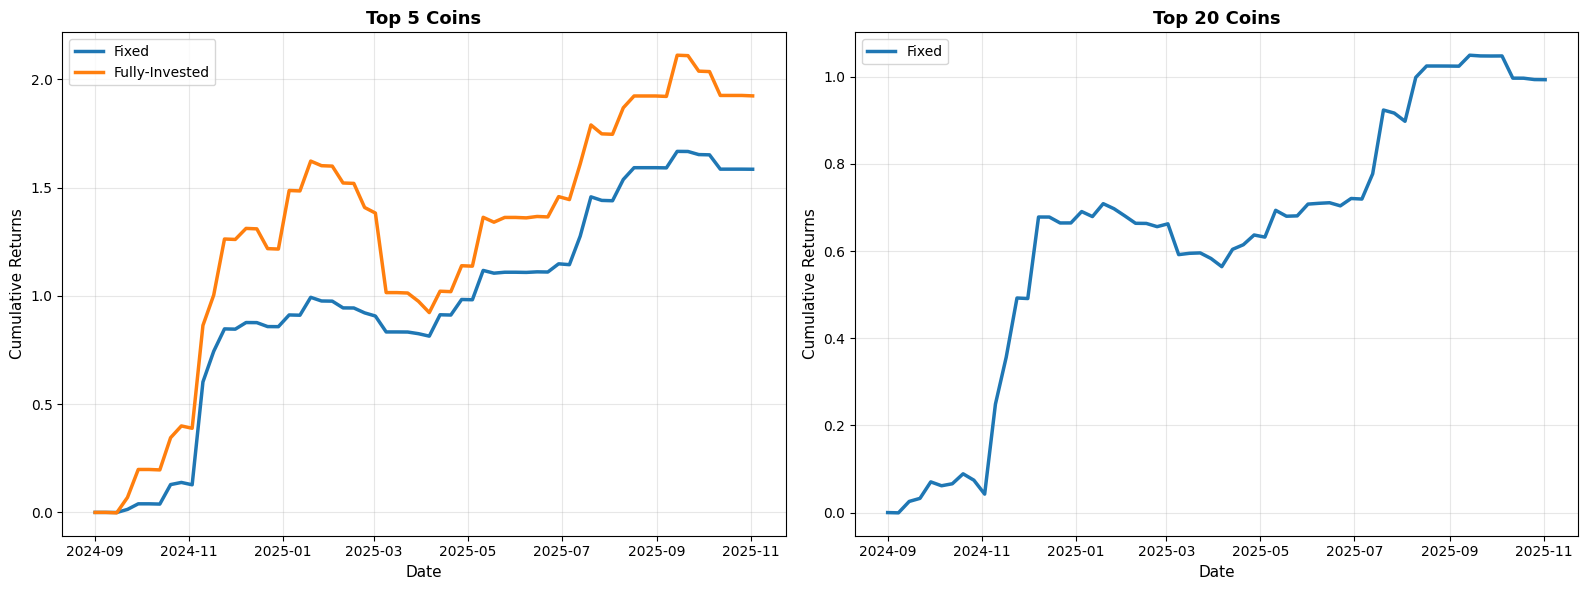

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
ax1.plot(cum_fixed.index, cum_fixed.values, label='Fixed', linewidth=2.5, color='#1f77b4')
ax1.plot(cum_fully.index, cum_fully.values, label='Fully-Invested', linewidth=2.5, color='#ff7f0e')
ax1.set_title('Top 5 Coins', fontsize=13, fontweight='bold')
ax1.set_ylabel('Cumulative Returns', fontsize=11)
ax1.set_xlabel('Date', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Top 20
ax2.plot(cum_fixed_20.index, cum_fixed_20.values, label='Fixed', linewidth=2.5, color='#1f77b4')
ax2.set_title('Top 20 Coins', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Returns', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Based on the highest sharpe out of sample we would choose the 5 coin fixed portfolio so ill plot that against benchmark

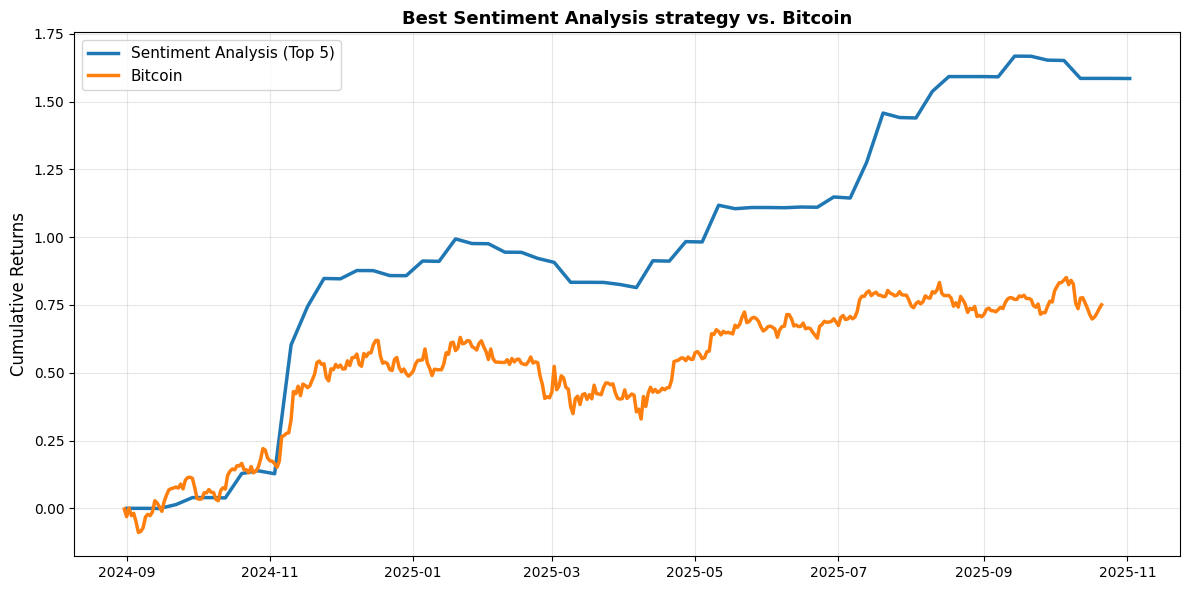

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(cum_fixed.index, cum_fixed.values, label='Sentiment Analysis (Top 5)', linewidth=2.5)
plt.plot(cum_btc.index, cum_btc.values, label='Bitcoin',linewidth=2.5 )
plt.ylabel('Cumulative Returns', fontsize=12)
plt.title('Best Sentiment Analysis strategy vs. Bitcoin', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [71]:
def compute_alpha_beta_metrics_weekly(strategy_returns, benchmark_returns):

    # Align the series
    aligned = pd.DataFrame({
        'strategy': strategy_returns,
        'benchmark': benchmark_returns
    }).dropna()
    
    X = aligned['benchmark']
    X = sm.add_constant(X)  
    Y = aligned['strategy']
    
    results = sm.OLS(Y, X).fit()
    
    alpha_daily = results.params['const']
    beta = results.params['benchmark']
    alpha_tstat = results.tvalues['const']
    
    alpha_annual = alpha_daily * 52
    
    # Information Ratio = (excess return) / tracking error
    tracking_error = results.resid.std() * np.sqrt(52)
    excess_annual_return = alpha_annual
    
    if tracking_error != 0:
        info_ratio = excess_annual_return / tracking_error
    else:
        info_ratio = 0
    
    return {
        'alpha_annual': alpha_annual,
        'beta': beta,
        'alpha_tstat': alpha_tstat,
        'info_ratio': info_ratio
    }

In [72]:
stats_delta_equal = compute_alpha_beta_metrics_weekly(delta_net['net_returns'], benchmark_returns)
stats_delta_fully = compute_alpha_beta_metrics_weekly(delta_fully_net['net_returns'], benchmark_returns)
stats_delta_equal_20 = compute_alpha_beta_metrics_weekly(delta_net_20['net_returns'], benchmark_returns)

results_df = pd.DataFrame([
    {'Strategy': 'Top 5 (Fixed)', **stats_delta_equal},
    {'Strategy': 'Top 5 (Fully-Invested)', **stats_delta_fully},
    {'Strategy': 'Top 20 (Fixed)', **stats_delta_equal_20},
    
])

print(results_df.to_string(index=False))

              Strategy  alpha_annual     beta  alpha_tstat  info_ratio
         Top 5 (Fixed)      1.341235 0.631217     2.616274    2.458754
Top 5 (Fully-Invested)      1.606922 1.197308     2.132010    2.003646
        Top 20 (Fixed)      0.839005 0.480870     2.521564    2.369746


**Top 5 Fixed dominates on risk-adjusted alpha**: With a t-statistic of 2.62 and an information ratio of 2.46, this configuration generates statistically robust excess returns beyond Bitcoin exposure. The moderate beta of 0.63 confirms genuine alpha generation rather than leveraged market exposure.

**Fully-invested shows higher alpha but excessive beta**: The 160.7% annual alpha comes with a 1.20 beta, indicating the strategy essentially mimics leveraged Bitcoin exposure with minimal independent alpha. The lower information ratio (2.00 vs 2.46) confirms it delivers less alpha per unit of idiosyncratic risk.

**Top 20 Fixed achieves statistical significance despite lower returns**: The 2.52 t-stat and 2.37 IR demonstrate that even with reduced returns (83.9% alpha), the 20-coin strategy maintains strong risk-adjusted performance through better diversification (beta = 0.48).

**Conclusion**: Top 5 Fixed offers the best balance—highest t-stat, highest information ratio, and meaningful alpha without excessive market beta.

In [73]:
def compute_complete_metrics_weekly(returns_df, weights_df, benchmark_returns, tcost_bps=20):
    
    # Calculate turnover
    turnover = (weights_df.fillna(0) - weights_df.shift().fillna(0)).abs().sum(axis=1)
    
    # Apply transaction costs
    net_returns = returns_df.subtract(turnover * tcost_bps * 1e-4, fill_value=0)
    
    # Basic metrics
    annual_return = net_returns.mean() * 52
    volatility = net_returns.std() * np.sqrt(52)
    sharpe_ratio = (net_returns.mean() / net_returns.std()) * np.sqrt(52)
    hit_rate = (net_returns > 0).sum() / len(net_returns)
    
    # Drawdown
    cumulative = net_returns.cumsum()
    running_max = cumulative.cummax()
    drawdown = cumulative - running_max
    max_drawdown = drawdown.min()
    
    # Max drawdown duration
    is_drawdown = drawdown < 0
    drawdown_periods = is_drawdown.astype(int).groupby((is_drawdown != is_drawdown.shift()).cumsum()).sum()
    max_dd_duration = drawdown_periods.max() if len(drawdown_periods) > 0 else 0
    
    # Holding period (average time in positions)
    # Assuming weights > 0 means you're holding
    in_position = (weights_df.sum(axis=1) > 0).astype(int)
    position_changes = (in_position != in_position.shift()).cumsum()
    position_durations = in_position.groupby(position_changes).sum()
    avg_holding_period = position_durations[position_durations > 0].mean()
    
    # Alpha/Beta regression
    aligned = pd.DataFrame({
        'strategy': net_returns,
        'benchmark': benchmark_returns
    }).dropna()

    correlation = aligned['strategy'].corr(aligned['benchmark'])
    
    X = aligned['benchmark']
    X = sm.add_constant(X)
    Y = aligned['strategy']
    results = sm.OLS(Y, X).fit()
    
    alpha_daily = results.params['const']
    beta = results.params['benchmark']
    alpha_tstat = results.tvalues['const']
    
    # Information Ratio
    tracking_error = results.resid.std() * np.sqrt(52)
    info_ratio = (alpha_daily * 52) / tracking_error if tracking_error != 0 else 0
    
    return {
        'Return (Ann.)': f"{annual_return:.2%}",
        'Volatility (Ann.)': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Hit Rate': f"{hit_rate:.2%}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Max DD Duration': f"{max_dd_duration:.0f} days",
        'Correlation to BTC': f"{correlation:.2f}",
        'Information Ratio': f"{info_ratio:.2f}",
        'Alpha (Ann.)': f"{alpha_daily * 52:.2%}",
        'Alpha t-stat': f"{alpha_tstat:.2f}",
        'Beta': f"{beta:.2f}"
    }

In [74]:
best_performer_delta = compute_complete_metrics_weekly(
    test_returns_delta, 
    weights_delta, 
    benchmark_returns, 
    tcost_bps=20
)

In [75]:
print("=" * 40)
print("Top 5 Coins (Fixed Weight) - Strategy Metrics")
print("=" * 40)
for key, value in best_performer_delta.items():
    print(f"{key:25} {value}")

Top 5 Coins (Fixed Weight) - Strategy Metrics
Return (Ann.)             132.93%
Volatility (Ann.)         54.78%
Sharpe Ratio              2.43
Hit Rate                  33.87%
Max Drawdown              -17.94%
Max DD Duration           15 days
Correlation to BTC        0.19
Information Ratio         2.46
Alpha (Ann.)              134.12%
Alpha t-stat              2.62
Beta                      0.63


## Part 3: Strategy Combination Analysis

Having established that both the **Channel Breakout** (technical) and **Sentiment Analysis** (Google Trends) strategies generate statistically significant alpha independently, we now explore whether combining them improves risk-adjusted performance.

The two strategies exploit fundamentally different alpha sources:
- **Channel Breakout**: Captures price momentum through technical breakout signals (daily frequency)
- **Sentiment Analysis**: Captures retail psychology shifts through search volume changes (weekly frequency)

In [76]:
delta_strat_ret = delta_net['net_returns']
cbr_strat_ret = metrics_equal['net_returns']

In [77]:
cbr_weekly = cbr_strat_ret.resample('W').sum()
print(cbr_weekly.corr(delta_strat_ret))

returns_matrix = pd.DataFrame({
    'CBR': cbr_weekly,
    'Delta': delta_strat_ret
}).dropna()

0.5775948871389818


Test 3 portfolio weighting schemes

- **opt**: Mean-variance optimization (maximize Sharpe ratio)
- **eqvol**: Equal volatility weighting (risk parity)
- **sr**: Sharpe ratio weighting (allocate proportional to standalone Sharpe)

In [78]:
def optimal_weights(sigma, mu):
    wgt = np.linalg.inv(sigma) @ mu
    wgt = wgt / np.abs(wgt).sum()
    return wgt

def eqvol_weights(sigma):
    wgt = 1 / np.sqrt(np.diag(sigma))
    wgt = wgt / np.abs(wgt).sum()
    return wgt

def sr_weights(sigma, mu):
    sharpes = mu / np.sqrt(np.diag(sigma))
    wgt = sharpes / np.abs(sharpes).sum()
    return wgt

In [79]:
sigma = returns_matrix.cov()
mu = returns_matrix.mean()

weights = {}
weights['opt'] = optimal_weights(sigma.values, mu.values)
weights['eqvol'] = eqvol_weights(sigma.values)
weights['sr'] = sr_weights(sigma.values, mu.values)

weights_df = pd.DataFrame(weights, index=['CBR', 'Delta'])
print("=== PORTFOLIO WEIGHTS ===")
print(weights_df)
print()

=== PORTFOLIO WEIGHTS ===
            opt     eqvol        sr
CBR    0.090592  0.601875  0.382676
Delta  0.909408  0.398125  0.617324



In [80]:
combo_rets = {}
combo_sharpes = {}

for method in ['opt', 'eqvol', 'sr']:
    combo_rets[method] = (returns_matrix.values @ weights[method])
    combo_sharpes[method] = combo_rets[method].mean() / combo_rets[method].std() * np.sqrt(52)
    
print("=== SHARPE RATIOS ===")
for method in ['opt', 'eqvol', 'sr']:
    print(f"{method}: {combo_sharpes[method]:.4f}")

print(f"\nDelta only: {delta_net['sharpe']:.4f}")
print(f"CRB-only: {metrics_equal['sharpe']:.4f}")

=== SHARPE RATIOS ===
opt: 2.4725
eqvol: 2.2518
sr: 2.4169

Delta only: 2.4264
CRB-only: 2.0426


The modest Sharpe improvement (2.47 vs 2.43) doesn't justify the added complexity of managing two strategies. **Deploy the Sentiment strategy standalone** for maximum simplicity and near-identical risk-adjusted returns. The combination only makes sense if you value the slightly lower beta from blending strategies, but the performance gain is negligible.

## Conclusion

This research demonstrates that systematic, rules-based strategies can generate statistically significant alpha in cryptocurrency markets. Both the technical channel breakout and sentiment-based Google Trends approaches substantially outperform passive Bitcoin exposure on a risk-adjusted basis.

The **sentiment analysis strategy emerges as superior**, delivering a 2.43 Sharpe ratio and 132.9% annual returns by exploiting retail search behavior changes. The **channel breakout strategy** offers a compelling lower-turnover alternative at 2.04 Sharpe and 56.9% returns, suitable for capital-efficient automated systems.

Portfolio construction choices proved more impactful than strategy selection—fixed-weight allocation's 40-85% Sharpe advantage over fully-invested approaches contradicts traditional asset management wisdom but reflects crypto's unique regime-dependent nature where signal quality trumps capital deployment.

For practitioners, we recommend the sentiment strategy for active managers seeking maximum risk-adjusted returns, and the channel breakout for those prioritizing simplicity and lower transaction costs. The moderate 0.58 correlation between strategies suggests limited diversification benefits, making standalone deployment optimal.

### Limitations and Future Research

The 2020-2025 backtest period captures one complete crypto cycle but includes potential survivorship bias and may not represent future market regimes. Transaction cost assumptions (20 bps) may underestimate true costs during volatility spikes. Google Trends data quality limits the sentiment strategy to established coins with sufficient search volume.

Future extensions could explore:
- Dynamic regime-based allocation between strategies
- Additional sentiment sources (Reddit, Twitter) beyond Google Trends
- Machine learning approaches to extract nonlinear patterns from sentiment data
- Options overlays to monetize volatility without adding directional exposure
